# Spectral Index Pipeline

Elaborating on the work done in previous sections, this section contains a complete implementation of the calculation of various spectral indicators.

It does not contain code to download products from the Open Access Hub[^download_process].
It is rather a re-usable notebook that can be re-used for the calculation of indices only.

The calculation in this notebook depends on three parameters:

- `product_path` is the path to a previously downloaded product
- `index_to_calculate` is one of the supported indices; these are 'ndvi'
  - bsi -- bare soil index
  - nbr -- normalized burn ratio
  - ndvi -- normalized difference in vegetation
  - ndwi -- normalized difference in water
- `fill_value`, the value which is used to represent invalid pixels to handle division by zero.

When running this notebook interactively, _Kernel → Restart and Run All Cells_ can be used to re-evaluate all cells in this notebook after configuring the pipeline.
The path of the output file containing the processed values will be printed below the last cell.

[^download_process]: See [](01 Download Process.ipynb) for details

In [5]:
from pathlib import Path

product_path = Path('resources/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip')
index_to_calculate = 'nbr'

## Product Preview

The following lines can be uncommented to plot a true-color image of the downloaded data:

In [6]:
#from sentinel_helpers import scihub_band_paths
#import rasterio.plot as rplot
#
#tci = scihub_band_paths(product_path, 'TCI', '60m')[0]
#with r.open(tci) as src:
#    rplot.show(src)

## Define Formulas

Formulas are defined as data so that the bands can be substituted with actual values later on. By declaratively  expressing the formula calculations computations can be executed lazily and only when needed. 
This is done so the formulas can be defined independent from actual data, which is needed only much later.

### Operators

Many spectral indicators can be expressed using band arithmetic with formulas similar to the NDVI:

$$
\text{NDVI} = \frac{\text{B08} - \text{B04}}{\text{B08} + \text{B04}}
$$

To define the index calculation formulas in this way, first the basic arithmetic operations `+`, `-`, `*` and `/` are wrapped in functions taking variadic arguments:

In [7]:
from functools import reduce

def add(nums):
    return reduce(lambda a, b: a + b, nums)

def sub(nums):
    return reduce(lambda a, b: a - b, nums)

def div(nums):
    return reduce(lambda a, b: a / b, nums)

def mul(nums):
    return reduce(lambda a, b: a * b, nums)

### Indices

These function are used to define formulas for the selection of indices mentioned in the introduction.
These indices are not exhaustive - there are many spectral indices which are not implemented in this notebook. The general shape of theses formulas however allows for enough flexibility to implement other indices as well.

The formulas are defined in a lisp-like prefix notation: `(add, 1, 2, 3)` translates to `1 + 2 + 3`.
Each element in a formula can be either a function, a string or a tuple. Tuples are delimited using `()`. The first element of these tuples is one of the operations defined above. It is followed by at least one other element, which can be any of the following:

- Tuples, allowing the recursive expression of formulas.
- Strings, which encode band numbers.
- Constants, i.e. integers or floats.

In [8]:
indices = {
    # normalized burn ratio
    'nbr': (div, (sub, 'B08', 'B12'), (add, 'B08', 'B12')),
    # normalized difference in vegetation
    'ndvi': (div, (sub, 'B08', 'B04'), (add, 'B08', 'B04')),
    # normalized difference in water index
    'ndwi': (div, (sub, 'B03', 'B08'), (add, 'B03', 'B08')),
    # bare soil index
    'bsi': (div, (sub, (add, 'B11', 'B04'), (add, 'B08', 'B02')),
                 (add, (add, 'B11', 'B04'), (add, 'B08', 'B02')))
}

An error is thrown if `index_to_calculate` does not mach any of the implements indices above:

In [9]:
supported_indices = ', '.join(indices.keys())
assert index_to_calculate in supported_indices, f'Only the following indices are supported: {supported_indices}'

### Resolving the Formulas

`get_bands` is a function function that returns all of the bands referenced in a recursive formula.
This is necessary to resolve these references to actual data sets.

In [10]:
def get_bands(formula):
    bands = set()
    for element in formula:
        if type(element) == tuple:
            # recur for subformulas
            for band in get_bands(element):
                bands.add(band)
        elif type(element) == str:
            bands.add(element)
    return bands

The resolving process needs a `band_map` in the form of `band_num` → `numpy.array`. By defining the arithmetic operations like above, it can be treated like any other python function - read from the formula and called using `op(args)`:

In [8]:
def evaluate_formula(band_map, formula):
    op = formula[0]
    args = []
    for element in formula[1:]:
        if type(element) == tuple:
            # recur on sub-formula
            args.append(evaluate_formula(band_map, element))
        elif type(element) == str:
            # substitute band number
            args.append(band_map[element])
        else:
            # just append the number
            args.append(element)
    return op(args)

Because the prefix-notation is not commonly used to define mathematical formula, a function is defined that converts prefix a formula from above to infix notation. This should help to avoid errors when transcribing the index formulas, which are usually given in common infix notation:

In [9]:
def prefix_to_infix_str(formula):
    '''
    Returns a human-readable string of the above data-based notation. Useful
    for debugging.
    '''
    result = ['(']
    
    # operation
    op = formula[0]
    if op == add:
        sym = ' + '
    elif op == sub:
        sym = ' - '
    elif op == div:
        sym = ' / '
    elif op == mul:
        sym = ' * '
        
    operands = formula[1:]
    for idx, operand in enumerate(operands, start=1):
        if type(operand) == tuple:
            result.append(prefix_to_infix_str(operand))
        else:
            result.append(str(operand))
        if idx < len(operands):
            result.append(sym)
        
    result.append(')')
    return ''.join(result)

#### Test Cases

In [10]:
formula = (add, *range(5), (mul, *range(1, 4))) # == (add, 0, 1, 2, 3, 4, (mul, 1, 2, 3))

In [11]:
prefix_to_infix_str(formula)

'(0 + 1 + 2 + 3 + 4 + (1 * 2 * 3))'

In [12]:
evaluate_formula({}, formula)

16

In [13]:
prefix_to_infix_str(indices['nbr'])

'((B08 - B12) / (B08 + B12))'

## Extraction of Relevant Band File Paths

Subsections from here on below contain the actual calculations.
They start with the list of bands are referenced by the index formula given by `index_to_calculate`:

In [14]:
bands = get_bands(indices[index_to_calculate])
bands = list(bands)
bands

['B08', 'B12']

## Resampling

Some bands are not available in all resolutions - the band `B08` for example is available only at a resolution of 10m and the band `B12` only up to 20m.

The lower-resolution bands are upsampled to the highest resolution band:

In [15]:
# sorting the band path alphabetically sorts the bands first by band number,
# then by resolution
from sentinel_helpers import scihub_band_paths

band_paths = sorted(scihub_band_paths(product_path, bands))
band_paths[:3]

[PosixPath('zip+file:/home/jovyan/sources/resources/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip!/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.SAFE/GRANULE/L2A_T33UUT_A016321_20180807T101024/IMG_DATA/R10m/T33UUT_20180807T101021_B08_10m.jp2'),
 PosixPath('zip+file:/home/jovyan/sources/resources/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip!/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.SAFE/GRANULE/L2A_T33UUT_A016321_20180807T101024/IMG_DATA/R20m/T33UUT_20180807T101021_B12_20m.jp2'),
 PosixPath('zip+file:/home/jovyan/sources/resources/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip!/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.SAFE/GRANULE/L2A_T33UUT_A016321_20180807T101024/IMG_DATA/R60m/T33UUT_20180807T101021_B12_60m.jp2')]

In [16]:
highest_resolution_band_paths = []

# covered_bands ensures that only the highest resolution band is kept
covered_bands = set()
for band in band_paths:
    band_num = band.name.split('_')[-2]
    if band_num in covered_bands:
        continue
    else:
        highest_resolution_band_paths.append(band)
        covered_bands.add(band_num)
        
def resolution(band_path):
    '''
    Return the resolution encoded in a raster file's path.
    '''
    if isinstance(band_path, Path):
        band_path = band_path.name
    
    return int(band_path.split('_')[-1].split('.')[0].replace('m', ''))

# using the function above, we parse the highest resolution out of the first band path
target_resolution = sorted(resolution(band) for band in highest_resolution_band_paths)[0]

## Raster Cloud Mask Generation

Spectral indices can get distorted by highly reflective clouds.
To avoid this the products include cloud masks, which contain information about the cloud positions in a product in order to discard them.

In order to construct a cloud mask that we can operate on, we need to know the transformation needed from the coordinates given by the raster's coordinate reference system to the pixel coordinates of the highest resolution raster.

These are encoded as metadata in the raster file:

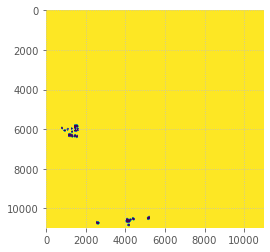

In [19]:
# pixels with clouds are True, pixels without are False
raster_cloud_mask = scihub_cloud_mask(product_path)

plt.imshow(raster_cloud_mask)

## Index Calculation

In [20]:
import numpy as np
import numpy.ma as ma

from rasterio.enums import Resampling
import rasterio.plot as rplt

from sentinel_helpers import RasterReaderList, scihub_cloud_mask
from tqdm.notebook import tqdm

from tempfile import NamedTemporaryFile

out_dir = Path('resources/spectral_indices/')
out_dir.mkdir(exist_ok=True, parents=True)

In [21]:
%%time

with RasterReaderList(highest_resolution_band_paths) as readers:
    # build the band_map as described above and scale up where needed
    band_map = {}
    for reader in tqdm(readers, desc='Resampling datasets'):
        band_num = reader.name.split('_')[-2]
        data_resolution = resolution(reader.name)
        scale_factor = int(data_resolution / target_resolution)
        out_shape = (
            int(reader.height * scale_factor),
            int(reader.width * scale_factor)
        )
        
        band_map[band_num] = (np.clip(
            # we read only the first band to obtain a two-dimensional ndarray
            reader.read(1, out_shape=out_shape, resampling=Resampling.bilinear, masked=True),
        0, 10000) / 10000).astype('float32')
        
        if scale_factor == 1:
            # this is the target resolution which defines the shape of the
            # raster file the data is written to
            out_name = Path(reader.name).name.replace(band_num, index_to_calculate.upper())
            out_name = out_name.replace('.jp2', '.tif')
            out_path = out_dir / out_name
            out_meta = reader.meta.copy()
    
    # ignore numpy division errors (i.e. divide by 0) in this context;
    # divide by zero results in `nan`. clouds are masked using the
    # raster_cloud_mask created above
    with np.errstate(divide='ignore', invalid='ignore'):
        index = evaluate_formula(band_map, indices[index_to_calculate])
        # we need to invert the cloud mask (`~`) because we want to hide those pixels that are cloudy
        tile_mask = ~raster_cloud_mask | index.mask
        index = ma.masked_array(index, tile_mask)
    
    out_meta.update({
        'count': 1,
        'driver': 'GTiff',
        'dtype': 'float32'
    })
    
    with r.open(out_path, 'w+', **out_meta) as dst:
        dst.write(index.data, 1)
        # note that the mask we write has an inverted interpretation of 
        # True / False due to the `.msk` file format
        dst.write_mask(~index.mask)
        print(f'Wrote result to {out_path}')


Wrote result to resources/spectral_indices/T33UUT_20180807T101021_NBR_10m.tif
CPU times: user 50.6 s, sys: 19.3 s, total: 1min 9s
Wall time: 39.6 s


In [22]:
# to debug the cloud / tile mask, uncomment these lines
# plt.imshow(tile_mask)

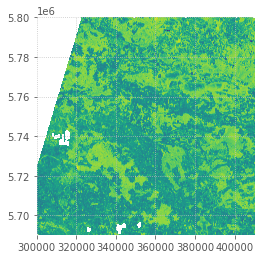

In [23]:
with r.open(out_path, 'r') as src:
    rplt.show(src)

In [24]:
# writing the mask explicitly works:
# dst.write(index.data, 1)
# dst.write_mask(~index.mask)